In [15]:
import matplotlib as mpl
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.colors as mcolors

def generate_barplots_single_metric(
    datasets: list,
    mode: str,
    base_colors: str,
    multimodal_colors: dict,
    data_dir: str,
    height: float = 0.4,
    alpha: float = 0.5,
    save: bool = True,
    output_path: str = "combined_scores_plot.png",
    scale_metric: bool = False,
    subplot_width: float = 1.0,
    rank_subplot_width: float = 0.8,   # width for the rank column
    title_fontsize: int = 7,
    row_fontsize: int = 8,
    data_rename_dict: dict = None,
    method_rename_dict: dict = None,
    pointsize: int = 2,
    bg_color: str = '#e0e0e0',
    rank_cmap: mpl.colors.Colormap = None,   # optional: custom rank colormap
):
    """
    Plot ONE metric across multiple datasets in a single figure with horizontal bars,
    and a rightmost 'Mean rank' column (colored squares with rank numbers).
    The entire bar plot region (including any spacing) is white; other areas use `bg_color`.

    Args:
        datasets (list): Dataset names.
        mode (str): One of "Directional_Consistency", "Temporal_Precision",
                    "Negative_Control_Robustness", "simulation1", or "simulation2".
        method_colors (dict): {method_name: color}.
        data_dir (str): Base directory where dataset folders are located.
        height (float): Bar height.
        alpha (float): Bar alpha.
        save (bool): Whether to save the plot.
        output_path (str): Save path when save=True.
        scale_metric (bool): If True, apply (score + 1) / 2 to all scores.
        subplot_width (float): Width for each dataset subplot.
        rank_subplot_width (float): Width for the rank column.
        title_fontsize (int): Font size for dataset titles.
        row_fontsize (int): Font size for y-tick (method) labels.
        data_rename_dict (dict): Mapping original dataset names -> display names.
        method_rename_dict (dict): Mapping original method names -> display names.
        pointsize (int): Size of scatter points (per-fold scores).
        bg_color (str): Background color outside the white bar region.
        rank_cmap (mpl.colors.Colormap): Colormap for rank squares (default: viridis).
    """
    # ---------------- Checks ----------------
    if not datasets:
        raise ValueError("Dataset list cannot be empty.")
    if not base_colors:
        raise ValueError("Method colors dictionary cannot be empty.")
    if mode not in [
        "Directional_Consistency_CBDir",
        "Directional_Consistency_ICVCoh",
        "Temporal_Precision",
        "Negative_Control_Robustness",
        "simulation1",
        "simulation2",
    ]:
        raise ValueError(
            "Mode must be one of 'Directional_Consistency', 'Temporal_Precision', "
            "'Negative_Control_Robustness', 'simulation1', or 'simulation2'."
        )

    # --------------- Helper(s) ---------------
    def get_contrasting_color(rgb):
        # Simple luminance-based contrast: return black/white text for colored squares
        if isinstance(rgb, (tuple, list)) and len(rgb) >= 3:
            r, g, b = rgb[:3]
        else:
            r, g, b, *_ = mpl.colors.to_rgba(rgb)
        luminance = 0.299 * r + 0.587 * g + 0.114 * b
        return "black" if luminance > 0.6 else "white"

    if rank_cmap is None:
        rank_cmap = plt.cm.coolwarm

    # --------------- Decide which file to load for the single metric ---------------
    def metric_path_for_mode(base_dir: Path, dataset: str) -> Path:
        if mode == "Directional_Consistency_CBDir":
            # Previously: CBDir and ICVCoh. Choose CBDir as the single metric by default.
            return base_dir / dataset /  "cbdir_df.csv"
        elif mode == "Directional_Consistency_ICVCoh":
            # Previously: CBDir and ICVCoh. Choose CBDir as the single metric by default.
            return base_dir / dataset /  "icvcoh_df.csv"
        elif mode == "Temporal_Precision":
            # Previously: CTO and Spearman. Choose Spearman.
            return base_dir / dataset /  "spearman_df.csv"
        elif mode == "Negative_Control_Robustness":
            # Previously: self_transition and normalized_entropy. Choose self_transition.
            return base_dir / dataset /  "self_transition_df.csv"
        elif mode == "simulation1":
            # Previously: cosine_similarity and pearson. Choose cosine_similarity.
            return base_dir / dataset /  "cosine_similarity_df.csv"
        elif mode == "simulation2":
            # Previously: distance_correlation and pearson. Choose distance_correlation.
            return base_dir / dataset / "distance_correlation_df.csv"
        else:
            raise ValueError("Invalid mode.")

    # --------------- Load data & collect methods ---------------
    base_dir = Path(data_dir)
    metric_dfs = {}
    all_methods = set()

    for dataset in datasets:
        mpath = metric_path_for_mode(base_dir, dataset)
        if not mpath.exists():
            raise FileNotFoundError(f"{mpath} not found.")
        df = pd.read_csv(mpath)
        # Ensure numeric
        df.iloc[:, 1:] = df.iloc[:, 1:].astype(np.float64)
        metric_dfs[dataset] = df
        all_methods.update(df["Method"].tolist())

    all_methods = sorted(list(all_methods))

    # --------------- Names & colors ---------------
    if method_rename_dict is None:
        method_rename_dict = {}
    display_methods = [method_rename_dict.get(m, m) for m in all_methods]

    # updated_colors = {
    #     method_rename_dict.get(m, m): method_colors.get(m, "#999999") for m in all_methods
    # }
    # method_colors = updated_colors

    # --------------- Theme ---------------
    sns.set_theme(style="white")

    # --------------- Figure & layout ---------------
    n_datasets = len(datasets)
    # We have `n_datasets` dataset columns + 1 rank column
    n_cols = n_datasets + 1
    rank_index = n_datasets
    width_ratios = [
        (rank_subplot_width if i == rank_index else subplot_width) for i in range(n_cols)
    ]
    total_fig_width = sum(width_ratios)

    fig, axes = plt.subplots(
        1,
        n_cols,
        figsize=(total_fig_width, 5),
        gridspec_kw={"wspace": 0.1, "hspace": 0.1, "width_ratios": width_ratios},
    )
    if n_cols == 1:
        axes = [axes]  # normalize list for single-col case
    fig.patch.set_facecolor(bg_color)

    # White bar region band
    bar_region_left, bar_region_right = 0.1, 0.9
    bar_region_bottom, bar_region_top = 0.1, 0.9
    fig.add_artist(
        Rectangle(
            (bar_region_left, bar_region_bottom),
            bar_region_right - bar_region_left,
            bar_region_top - bar_region_bottom,
            transform=fig.transFigure,
            facecolor="white",
            edgecolor="none",
            zorder=-1,
        )
    )
    for ax in axes:
        for side in ("top", "right", "bottom", "left"):
            ax.spines[side].set_visible(False)
        ax.set_facecolor("white")

    # --------------- Compute per-dataset means/stds and raw scores ---------------
    metric_means = {m: [] for m in all_methods}
    metric_stds  = {m: [] for m in all_methods}
    metric_scores = {m: [] for m in all_methods}

    for j, dataset in enumerate(datasets):
        df = metric_dfs[dataset]
        for method in all_methods:
            if method in df["Method"].values:
                vals = df[df["Method"] == method].iloc[0, 1:].to_numpy()
                if scale_metric:
                    vals = (vals + 1) / 2
                metric_scores[method].append(vals)
                metric_means[method].append(vals.mean())
                # ddof=1 if >=2 folds; handle single-fold safely:
                ddof = 1 if vals.size >= 2 else 0
                metric_stds[method].append(vals.std(ddof=ddof))
            else:
                # method not present for this dataset
                metric_scores[method].append(np.full(1, np.nan))
                metric_means[method].append(np.nan)
                metric_stds[method].append(np.nan)

    # --------------- Mean across datasets & ranks ---------------
    mean_of_means = {m: np.nanmean(metric_means[m]) for m in all_methods}
    rank_series = pd.Series(mean_of_means).rank(ascending=False, method="min")
    ranks = rank_series.astype(int).to_dict()

    # Reorder methods by rank (best first or last?). Keeping your previous reverse=True behavior:
    all_methods = sorted(all_methods, key=lambda x: ranks.get(x, np.inf), reverse=True)
    display_methods = [method_rename_dict.get(m, m) for m in all_methods]
    method_to_color_sorted = {
        display_methods[i]: base_colors[-1 - i]
        for i in range(len(display_methods))
    }
    method_to_color_sorted.update(multimodal_colors)
    print(method_to_color_sorted)
    oldname_to_color = {
        old_name: method_to_color_sorted[ method_rename_dict.get(old_name, old_name) ]
        for old_name in method_rename_dict.keys()
    }

    # Rank coloring
    max_rank_val = max(ranks.values()) if len(ranks) else 1
    rank_norm = mpl.colors.Normalize(vmin=1, vmax=max_rank_val)

    def rank_color(rank: int):
        return rank_cmap(rank_norm(rank))

    # --------------- Draw dataset columns ---------------
    for j in range(n_datasets):
        ax = axes[j]
        for i, method in enumerate(all_methods):
            mu = metric_means[method][j]
            if not np.isnan(mu):
                disp_name = method_rename_dict.get(method, method)
                ax.barh(
                    i,
                    mu,
                    color=method_to_color_sorted.get(disp_name, "#999999"),
                    height=height,
                    alpha=alpha,
                    edgecolor="none",
                )
                # ax.errorbar(
                #     mu,
                #     i,
                #     xerr=metric_stds[method][j],
                #     fmt="none",
                #     ecolor="black",
                #     capsize=3,
                #     capthick=1,
                #     elinewidth=1,
                # )
                scores = metric_scores[method][j]
                ax.scatter(
                    scores,
                    np.full_like(scores, i),
                    color="black",
                    s=pointsize,
                    alpha=0.8,
                    zorder=10,
                    marker="o",
                    facecolors=None,
                    edgecolors="black",
                )
        ax.set_ylim(-0.5, len(all_methods) - 0.5)
        if j == 0:
            ax.set_yticks(range(len(all_methods)))
            ax.set_yticklabels(display_methods, fontsize=row_fontsize)
        else:
            ax.set_yticks([])
        title_text = data_rename_dict.get(datasets[j], datasets[j]) if data_rename_dict else datasets[j]
        ax.set_title(title_text, fontsize=title_fontsize)
        ax.set_xticks([])

    # --------------- Draw Mean rank column ---------------
    ax_rank = axes[rank_index]
    for i, method in enumerate(all_methods):
        r = ranks[method]
        # color = rank_color(r)
        color = oldname_to_color[method]
        ax_rank.add_patch(
            patches.FancyBboxPatch(
                (0.42, i - 0.3),
                0.16,
                0.6,
                boxstyle="square,pad=0",
                facecolor=color,
                edgecolor="none",
            )
        )
        ax_rank.text(
            0.5,
            i,
            str(r),
            ha="center",
            va="center",
            fontsize=5,
            color = 'white'
            # color=get_contrasting_color(color),
        )
    ax_rank.set_xlim(0, 1)
    ax_rank.set_ylim(-0.5, len(all_methods) - 0.5)
    ax_rank.set_yticks([])
    ax_rank.set_title("Mean rank", fontsize=title_fontsize)
    ax_rank.set_xticks([])
    ax_rank.axis("off")

    # --------------- Layout tweaks ---------------
    fig.subplots_adjust(
        left=bar_region_left,
        right=bar_region_right,
        bottom=bar_region_bottom,
        top=bar_region_top,
    )

    # --------------- Save / show ---------------
    if save:
        plt.savefig(output_path, dpi=300, bbox_inches="tight")
    else:
        plt.show()
    plt.close()

In [2]:
import numpy as np

def generate_gradient_colors(color_start, color_end, n_colors=28):

    def hex_to_rgb(hex_color):
        hex_color = hex_color.lstrip('#')
        return np.array([int(hex_color[i:i+2], 16) for i in (0, 2, 4)])

    def rgb_to_hex(rgb):
        return '#%02x%02x%02x' % tuple(rgb.astype(int))

    start_rgb = hex_to_rgb(color_start)
    end_rgb = hex_to_rgb(color_end)

    gradient = [
        rgb_to_hex(start_rgb + (end_rgb - start_rgb) * i / (n_colors - 1))
        for i in range(n_colors)
    ]

    return gradient

color_start = "#9B4545"   
color_end   = "#E1B2B2"   

base_colors = generate_gradient_colors(color_start, color_end, 28)

In [3]:
methods = ['velocyto','scvelo_dyn','scvelo_stc','veloae','dynamo_m1','unitvelo_ind','unitvelo_uni',
           'velovae_std','velovae_fullvb','deepvelo','celldancer',
           'pyrovelocity_m1','pyrovelocity_m2','kvelo','velovi','sdevelo','cell2fate','svelvetvae',
             'latentvelo_std', 'tivelo_std', 'tivelo_simple', 'sctour_mse',
           'sctour_nb', 'sctour_zinb', 'velvetvae','dynamo_m2' 'graphvelo_std', ]

ground_truth_mouse_brain = [('RG, Astro, OPC', 'IPC'), ('IPC', 'V-SVZ'), ('V-SVZ', 'Upper layer'), ('Upper layer', 'Deeper layer')]
ground_truth_mouse_skin = [('TAC-1', 'TAC-2'), ('TAC-2', 'Hair shaft cuticle/cortex'), ('TAC-2', 'IRS'), ('TAC-2', 'Medulla')]
ground_truth_HSPC = [("HSC", "MPP"), ("MPP", "LMPP"),  ("LMPP", "GMP"), ("HSC", "MEP"), ("MEP", "Erythrocyte"),
                 ("MEP", "Prog MK"), ("Prog MK", "Platele")]

method_rename_dict = {
        'velocyto': "Velocyto",
        'scvelo_dyn': "scVelo (dyn)",
        'scvelo_stc': "scVelo (stc)",
        'veloae': "VeloAE",
        'dynamo_m1': "Dynamo (m1)",
        'unitvelo_ind': "UniTVelo (ind)",
        'unitvelo_uni': "UniTVelo (uni)",
        'velovae_std': "VeloVAE (std)",
        'velovae_fullvb': "VeloVAE (Full VB)",
        'deepvelo': "DeepVelo",
        'celldancer': "cellDancer",
        'pyrovelocity_m1': "Pyro-Velocity (m1)",
        'pyrovelocity_m2': "Pyro-Velocity (m2)",
        'kvelo': "κ-velo", # κ
        'velovi': "veloVI",
        'cell2fate': "cell2fate",
        'sdevelo': "SDEvelo",
        'svelvetvae': "SvelvetVAE",
        'latentvelo_std': "LatentVelo (std)",
        'tivelo_std': "TIVelo (std)",
        'tivelo_simple': "TIVelo (simple)",
        'sctour_mse': "scTour (MSE)",
        'sctour_nb': "scTour (NB)",
        'sctour_zinb': "scTour (ZINB)",
        'graphvelo_std': "GraphVelo (std)",
        'dynamo_m2': "Dynamo (m2)",
        'velvetvae': 'VelvetVAE'}


In [4]:
multimodal_colors = {
   "Dynamo (m2)": "#2A7486",
   "VelvetVAE": "#76B8C9",
   "Dynamo (m1)": "#F65E51",
   "SvelvetVAE" : "#F98C84",
}

datasets = ["data05", 
            "data20"]
generate_barplots_single_metric(datasets, 
                        "Directional_Consistency_CBDir",
                        base_colors,
                        multimodal_colors, 
                        subplot_width=1,
                        scale_metric=True,
                        title_fontsize=7,
                        row_fontsize=6,
                        pointsize=1,
                        data_dir="./", 
                        data_rename_dict={
                            "data05": "Data 5",
                            "data20": "Data 20"
                        },
                        method_rename_dict=method_rename_dict,
                        alpha = 1.0,
                        save= True,
                        output_path=f"Label_CBDir_rank.svg")

{'UniTVelo (uni)': '#e1b2b2', 'SDEvelo': '#deadad', 'κ-velo': '#dba9a9', 'DeepVelo': '#d9a5a5', 'scVelo (dyn)': '#d6a1a1', 'cellDancer': '#d49d9d', 'scTour (ZINB)': '#d19999', 'TIVelo (std)': '#ce9595', 'TIVelo (simple)': '#cc9191', 'scTour (NB)': '#c98d8d', 'cell2fate': '#c78989', 'Dynamo (m1)': '#F65E51', 'Velocyto': '#c18181', 'VeloAE': '#bf7d7d', 'LatentVelo (std)': '#bc7979', 'VelvetVAE': '#76B8C9', 'scTour (MSE)': '#b77171', 'scVelo (stc)': '#b46d6d', 'UniTVelo (ind)': '#b26969', 'SvelvetVAE': '#F98C84', 'GraphVelo (std)': '#ad6161', 'VeloVAE (std)': '#aa5d5d', 'VeloVAE (Full VB)': '#a75959', 'veloVI': '#a55555', 'Dynamo (m2)': '#2A7486', 'Pyro-Velocity (m2)': '#a04d4d', 'Pyro-Velocity (m1)': '#9d4949'}


In [5]:
multimodal_colors = {
   "Dynamo (m2)": "#2A7486",
   "VelvetVAE": "#76B8C9",
   "Dynamo (m1)": "#F65E51",
   "SvelvetVAE" : "#F98C84",
}

datasets = ["data06", 
            "data19"]
generate_barplots_single_metric(datasets, 
                        "Temporal_Precision",
                        base_colors,
                        multimodal_colors, 
                        subplot_width=1,
                        scale_metric=True,
                        title_fontsize=7,
                        row_fontsize=6,
                        pointsize=1,
                        data_dir="./", 
                        data_rename_dict={
                            "data06": "Data 6",
                            "data19": "Data 19"
                        },
                        method_rename_dict=method_rename_dict,
                        alpha = 1.0,
                        save= True,
                        output_path=f"Label_TSC_rank.svg")

{'veloVI': '#e1b2b2', 'SDEvelo': '#deadad', 'Pyro-Velocity (m1)': '#dba9a9', 'scTour (NB)': '#d9a5a5', 'LatentVelo (std)': '#d6a1a1', 'Pyro-Velocity (m2)': '#d49d9d', 'scTour (MSE)': '#d19999', 'VeloVAE (std)': '#ce9595', 'scTour (ZINB)': '#cc9191', 'cell2fate': '#c98d8d', 'UniTVelo (ind)': '#c78989', 'SvelvetVAE': '#F98C84', 'VeloVAE (Full VB)': '#c18181', 'VelvetVAE': '#76B8C9', 'TIVelo (std)': '#bc7979', 'TIVelo (simple)': '#ba7575', 'Dynamo (m2)': '#2A7486', 'scVelo (dyn)': '#b46d6d', 'DeepVelo': '#b26969', 'κ-velo': '#af6565', 'UniTVelo (uni)': '#ad6161', 'cellDancer': '#aa5d5d', 'VeloAE': '#a75959', 'scVelo (stc)': '#a55555', 'Dynamo (m1)': '#F65E51', 'GraphVelo (std)': '#a04d4d', 'Velocyto': '#9d4949'}


In [6]:
import scanpy as sc
import scvelo as scv
from scipy.sparse import issparse

In [7]:
methods_for_label = ["dynamo_m2", 
                    "dynamo_m1", 
                    "velvetvae", 
                    "svelvetvae"]
embed_key = 'X_umap'
umap_colors = [
    '#1f77b4', 
    '#ff7f0e', 
    '#2ca02c', 
    '#d62728', 
    '#9467bd', 
    '#8c564b',
    '#e377c2',
    "#7f7f7f",
]

Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph (using 20/24 cores)


  0%|          | 0/1373 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'dynamo_m2_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'dynamo_m2_velocity_umap', embedded velocity vectors (adata.obsm)


/home/edawu/anaconda3/envs/evaluation/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/edawu/anaconda3/envs/evaluation/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


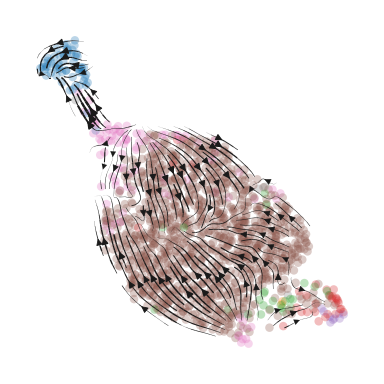

computing velocity graph (using 20/24 cores)


  0%|          | 0/1373 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'dynamo_m1_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'dynamo_m1_velocity_umap', embedded velocity vectors (adata.obsm)


/home/edawu/anaconda3/envs/evaluation/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/edawu/anaconda3/envs/evaluation/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


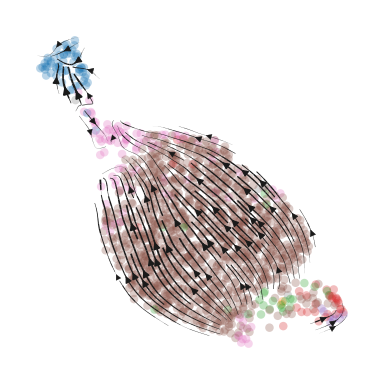

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph (using 20/24 cores)


  0%|          | 0/1373 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velvetvae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velvetvae_velocity_umap', embedded velocity vectors (adata.obsm)


/home/edawu/anaconda3/envs/evaluation/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/edawu/anaconda3/envs/evaluation/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


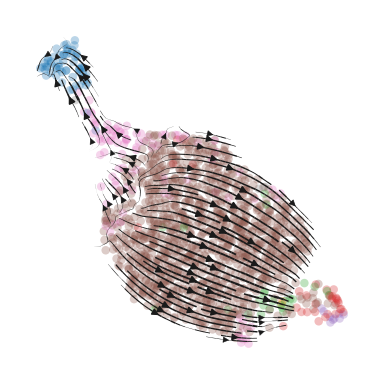

computing velocity graph (using 20/24 cores)


  0%|          | 0/1373 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'svelvetvae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'svelvetvae_velocity_umap', embedded velocity vectors (adata.obsm)


/home/edawu/anaconda3/envs/evaluation/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/edawu/anaconda3/envs/evaluation/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


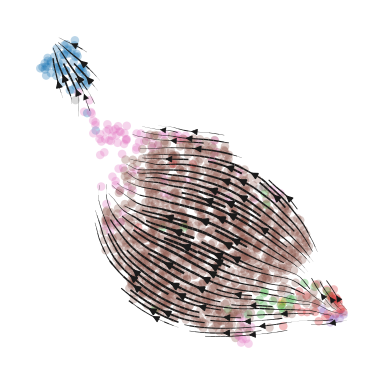

In [ ]:
dataset = 'data05' #umap, cell_type
# dataset = 'data20' #umap, cell_type
# dataset = 'data06' #umap, time,
# dataset = 'data19' #umap, dtime
cluster_key = 'cell_type'

for method in methods_for_label:
    vkey = f"{method}_velocity"

    adata = sc.read_h5ad( Path(dataset) / f"adata_run_{method}_full.h5ad")

    if issparse(adata.layers[vkey]):
        adata.layers[vkey] = adata.layers[vkey].toarray().astype(np.float32)
    adata.layers[vkey] = np.where(np.isnan(adata.layers[vkey]), 0, adata.layers[vkey])
    sqrt_transform = False


    if method == 'dynamo_m2' or method == 'velvetvae':
        adata.layers['unspliced'] = adata.layers['new']
        adata.layers['spliced'] = adata.layers['total']
        scv.pp.moments(adata, n_neighbors=30, n_pcs=30)
    
    scv.tl.velocity_graph(adata, vkey=vkey, sqrt_transform=sqrt_transform,n_jobs=20)

    adata.uns[f'{cluster_key}_colors'] = umap_colors
    adata.obs[cluster_key] = adata.obs[cluster_key].astype("category")
    cluster_order = adata.obs[cluster_key].cat.categories
    cell_types = adata.obs[cluster_key].values
    unique_types = np.unique(cell_types)
    color_map = {ct: umap_colors[i % len(umap_colors)] for i, ct in enumerate(unique_types)}
    adata.uns[f'{cluster_key}_colors'] = [color_map[c] for c in cluster_order]
    kwargs = dict(
        frameon=True, add_margin=.1,
        size=150
    )
    # atac size = 120
    fig, ax = plt.subplots(figsize=(4, 4))
    scv.pl.velocity_embedding_stream(
        adata,
        color=cluster_key,
        vkey=vkey,
        basis='umap',
        title='',
        # legend_loc = 'upper right',
        legend_loc='none',
        ax=ax,
        **kwargs,
        show=False
    )
    ax.set_title('')
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(f"{method}_{dataset}_stream.png", bbox_inches='tight', dpi=300)
    plt.show()

Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph (using 20/24 cores)


  0%|          | 0/1947 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'dynamo_m2_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'dynamo_m2_velocity_umap', embedded velocity vectors (adata.obsm)


/home/edawu/anaconda3/envs/evaluation/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/edawu/anaconda3/envs/evaluation/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


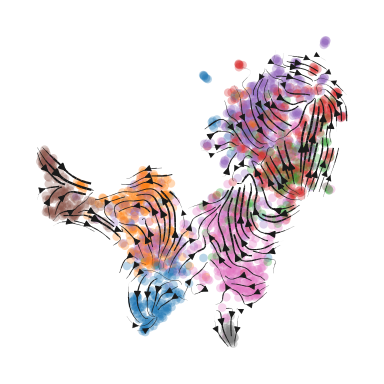

computing velocity graph (using 20/24 cores)


  0%|          | 0/1947 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'dynamo_m1_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'dynamo_m1_velocity_umap', embedded velocity vectors (adata.obsm)


/home/edawu/anaconda3/envs/evaluation/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/edawu/anaconda3/envs/evaluation/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


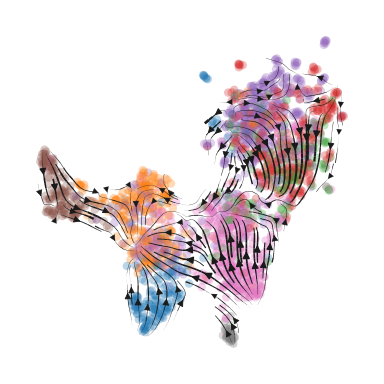

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph (using 20/24 cores)


  0%|          | 0/1947 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velvetvae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velvetvae_velocity_umap', embedded velocity vectors (adata.obsm)


/home/edawu/anaconda3/envs/evaluation/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/edawu/anaconda3/envs/evaluation/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


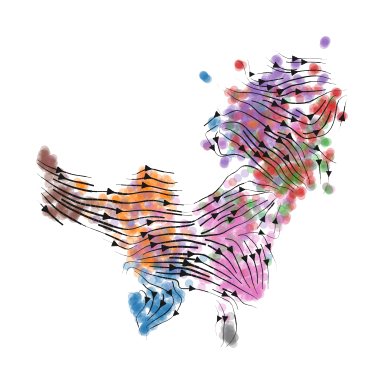

computing velocity graph (using 20/24 cores)


  0%|          | 0/1947 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'svelvetvae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'svelvetvae_velocity_umap', embedded velocity vectors (adata.obsm)


/home/edawu/anaconda3/envs/evaluation/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/edawu/anaconda3/envs/evaluation/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


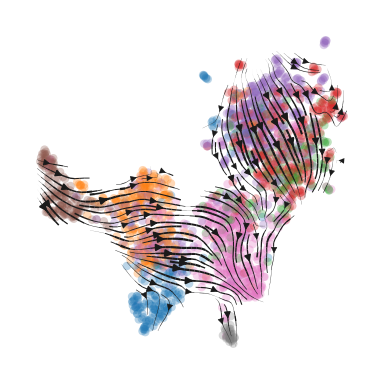

In [14]:
# dataset = 'data05' #umap, cell_type
dataset = 'data20' #umap, cell_type
# dataset = 'data06' #umap, time,
# dataset = 'data19' #umap, dtime
cluster_key = 'cell_type'

for method in methods_for_label:
    vkey = f"{method}_velocity"

    adata = sc.read_h5ad( Path(dataset) / f"adata_run_{method}_full.h5ad")

    if issparse(adata.layers[vkey]):
        adata.layers[vkey] = adata.layers[vkey].toarray().astype(np.float32)
    adata.layers[vkey] = np.where(np.isnan(adata.layers[vkey]), 0, adata.layers[vkey])
    sqrt_transform = False


    if method == 'dynamo_m2' or method == 'velvetvae':
        adata.layers['unspliced'] = adata.layers['new']
        adata.layers['spliced'] = adata.layers['total']
        scv.pp.moments(adata, n_neighbors=30, n_pcs=30)
    
    scv.tl.velocity_graph(adata, vkey=vkey, sqrt_transform=sqrt_transform,n_jobs=20)

    adata.uns[f'{cluster_key}_colors'] = umap_colors
    adata.obs[cluster_key] = adata.obs[cluster_key].astype("category")
    cluster_order = adata.obs[cluster_key].cat.categories
    cell_types = adata.obs[cluster_key].values
    unique_types = np.unique(cell_types)
    color_map = {ct: umap_colors[i % len(umap_colors)] for i, ct in enumerate(unique_types)}
    adata.uns[f'{cluster_key}_colors'] = [color_map[c] for c in cluster_order]
    kwargs = dict(
        frameon=True, add_margin=.1,
        size=150
    )
    # atac size = 120
    fig, ax = plt.subplots(figsize=(4, 4))
    scv.pl.velocity_embedding_stream(
        adata,
        color=cluster_key,
        vkey=vkey,
        basis='umap',
        title='',
        # legend_loc = 'upper right',
        legend_loc='none',
        ax=ax,
        **kwargs,
        show=False
    )
    ax.set_title('')
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(f"{method}_{dataset}_stream.png", bbox_inches='tight', dpi=300)
    plt.show()

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph (using 8/24 cores)


  0%|          | 0/3060 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'dynamo_m2_velocity_graph', sparse matrix with cosine correlations (adata.uns)
dynamo_m2_time already exists. Using existing values.


/home/edawu/anaconda3/envs/evaluation/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


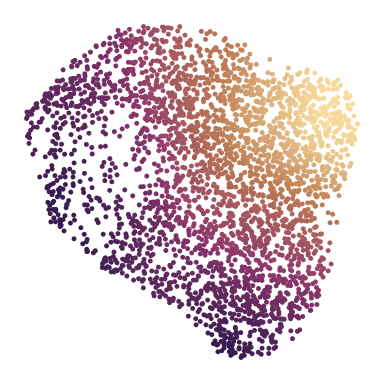

computing velocity graph (using 8/24 cores)


  0%|          | 0/3060 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'dynamo_m1_velocity_graph', sparse matrix with cosine correlations (adata.uns)
dynamo_m1_time already exists. Using existing values.


/home/edawu/anaconda3/envs/evaluation/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


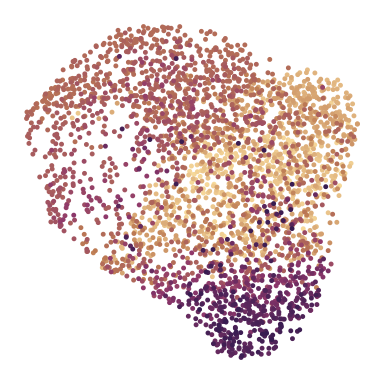

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph (using 8/24 cores)


  0%|          | 0/3060 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velvetvae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
velvetvae_time not found. Computing velocity pseudotime...
computing terminal states
    identified 4 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


/home/edawu/anaconda3/envs/evaluation/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


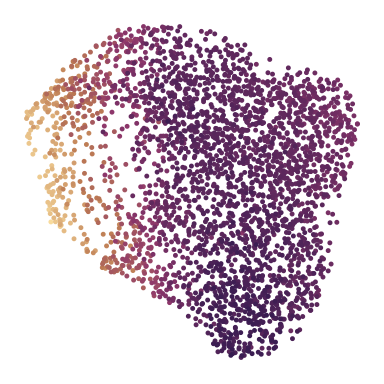

computing velocity graph (using 8/24 cores)


  0%|          | 0/3060 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'svelvetvae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
svelvetvae_time not found. Computing velocity pseudotime...
computing terminal states
    identified 6 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


/home/edawu/anaconda3/envs/evaluation/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


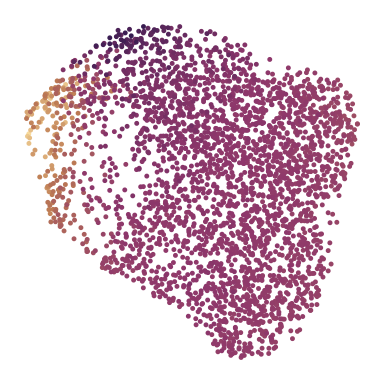

In [18]:
dataset = 'data06'

adata = sc.read_h5ad( Path(dataset) / f"adata_run_dynamo_m2_full.h5ad")
X_umap = adata.obsm['X_umap'].copy()
for method in methods_for_label:

    vkey = f"{method}_velocity"

    adata = sc.read_h5ad( Path(dataset) / f"adata_run_{method}_full.h5ad")
    adata.obsm['X_umap'] = X_umap

    if issparse(adata.layers[vkey]):
        adata.layers[vkey] = adata.layers[vkey].toarray().astype(np.float32)
    adata.layers[vkey] = np.where(np.isnan(adata.layers[vkey]), 0, adata.layers[vkey])

    sqrt_transform = False

    if method == 'dynamo_m2' or method == 'velvetvae':
        adata.layers['unspliced'] = adata.layers['new']
        adata.layers['spliced'] = adata.layers['total']
        scv.pp.moments(adata, n_neighbors=30, n_pcs=30)
    
    scv.tl.velocity_graph(adata, 
                          vkey=vkey,
                          sqrt_transform=sqrt_transform, 
                          n_jobs=8)

    time_key = f"{method}_time"

    if time_key not in adata.obs.columns:
        print(f"{time_key} not found. Computing velocity pseudotime...")
        scv.tl.velocity_pseudotime(adata, vkey=vkey)
        adata.obs[time_key] = adata.obs[f'{vkey}_pseudotime']
    else:
        print(f"{time_key} already exists. Using existing values.")


    fig, ax = plt.subplots(figsize=(4, 4))

    morandi_list = ["#F8DB9C", "#BD7B53", "#8E376B", "#351B50"]
    
    cmap = mcolors.LinearSegmentedColormap.from_list("morandi_clt", morandi_list)
    scv.pl.scatter(
        adata,
        basis="umap",
        color=time_key,
        cmap=cmap,
        colorbar=False,
        size=50,
        ax=ax,
        title=f"",
        show=False
    )

    plt.tight_layout()
    plt.savefig(
        "{method}_{dataset}_time_umap.png",
        bbox_inches='tight',
        dpi=300
    )
    plt.show()

Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph (using 8/24 cores)


  0%|          | 0/2793 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'dynamo_m2_velocity_graph', sparse matrix with cosine correlations (adata.uns)
dynamo_m2_time already exists. Using existing values.


/home/edawu/anaconda3/envs/evaluation/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


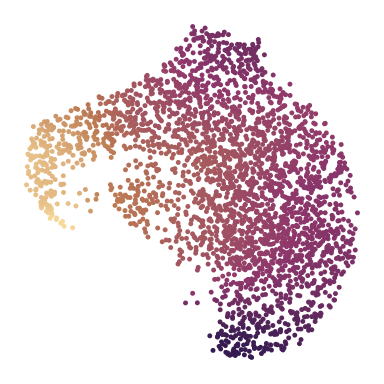

computing velocity graph (using 8/24 cores)


  0%|          | 0/2793 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'dynamo_m1_velocity_graph', sparse matrix with cosine correlations (adata.uns)
dynamo_m1_time already exists. Using existing values.


/home/edawu/anaconda3/envs/evaluation/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


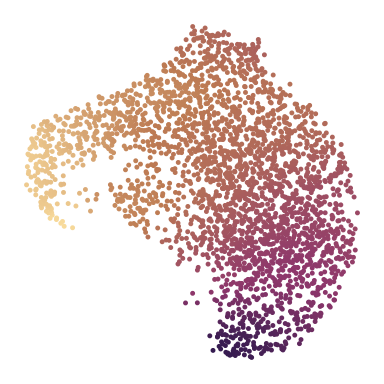

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph (using 8/24 cores)


  0%|          | 0/2793 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velvetvae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
velvetvae_time not found. Computing velocity pseudotime...
computing terminal states
    identified 3 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


/home/edawu/anaconda3/envs/evaluation/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


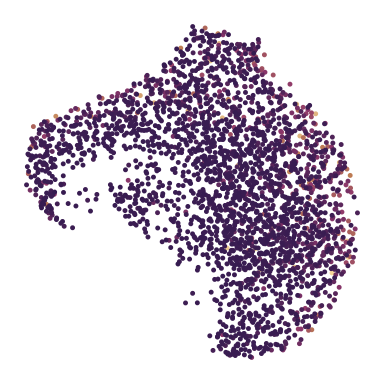

computing velocity graph (using 8/24 cores)


  0%|          | 0/2793 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'svelvetvae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
svelvetvae_time not found. Computing velocity pseudotime...
computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


/home/edawu/anaconda3/envs/evaluation/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


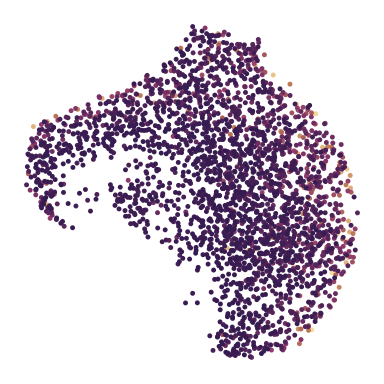

In [19]:
dataset = 'data19'

adata = sc.read_h5ad( Path(dataset) / f"adata_run_dynamo_m2_full.h5ad")
X_umap = adata.obsm['X_umap'].copy()
for method in methods_for_label:

    vkey = f"{method}_velocity"

    adata = sc.read_h5ad( Path(dataset) / f"adata_run_{method}_full.h5ad")
    adata.obsm['X_umap'] = X_umap

    if issparse(adata.layers[vkey]):
        adata.layers[vkey] = adata.layers[vkey].toarray().astype(np.float32)
    adata.layers[vkey] = np.where(np.isnan(adata.layers[vkey]), 0, adata.layers[vkey])

    sqrt_transform = False

    if method == 'dynamo_m2' or method == 'velvetvae':
        adata.layers['unspliced'] = adata.layers['new']
        adata.layers['spliced'] = adata.layers['total']
        scv.pp.moments(adata, n_neighbors=30, n_pcs=30)
    
    scv.tl.velocity_graph(adata, 
                          vkey=vkey,
                          sqrt_transform=sqrt_transform, 
                          n_jobs=8)

    time_key = f"{method}_time"

    if time_key not in adata.obs.columns:
        print(f"{time_key} not found. Computing velocity pseudotime...")
        scv.tl.velocity_pseudotime(adata, vkey=vkey)
        adata.obs[time_key] = adata.obs[f'{vkey}_pseudotime']
    else:
        print(f"{time_key} already exists. Using existing values.")


    fig, ax = plt.subplots(figsize=(4, 4))

    morandi_list = ["#F8DB9C", "#BD7B53", "#8E376B", "#351B50"]
    
    cmap = mcolors.LinearSegmentedColormap.from_list("morandi_clt", morandi_list)
    scv.pl.scatter(
        adata,
        basis="umap",
        color=time_key,
        cmap=cmap,
        colorbar=False,
        size=50,
        ax=ax,
        title=f"",
        show=False
    )

    plt.tight_layout()
    plt.savefig(
        "{method}_{dataset}_time_umap.png",
        bbox_inches='tight',
        dpi=300
    )
    plt.show()